This notebook is my attempt at developing a DDPG model for stock market investment, training and testing will be done on the DJIA.

Code based on https://github.com/keras-team/keras-io/blob/master/examples/rl/ddpg_pendulum.py and https://arxiv.org/abs/1811.07522 and the DDPG original paper

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from enviroment import Simulate_Portfolio
from datetime import datetime, timedelta
import keras
import yfinance as yf


Create enviroment and datasets

In [2]:
training_years = 6
validation_years = 1
testing_years = 1
start_datetime = datetime.now() - timedelta(weeks=52*training_years)
validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)


In [3]:
df1 = porfolio.investments['GOOG'].history(start = start_datetime, end = datetime.now(), interval = '1d')

df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-02 00:00:00-04:00,59.442219,59.442219,58.166449,58.431637,32302000,0.0,0.0
2019-10-03 00:00:00-04:00,58.598990,59.048910,57.726459,58.987827,32424000,0.0,0.0
2019-10-04 00:00:00-04:00,59.189450,60.160304,59.054373,60.039135,23248000,0.0,0.0
2019-10-07 00:00:00-04:00,59.810704,60.496210,59.778424,59.973587,16858000,0.0,0.0
2019-10-08 00:00:00-04:00,59.472516,59.894131,59.046431,59.052391,20786000,0.0,0.0


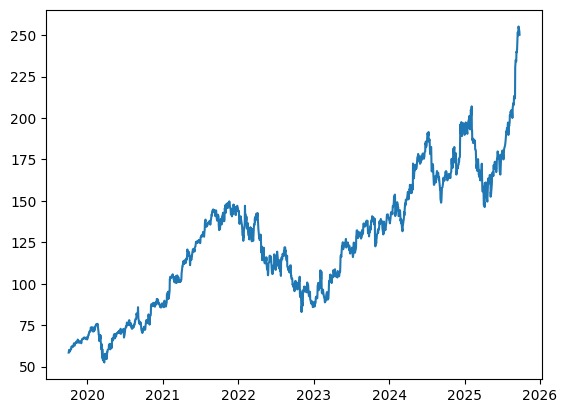

In [4]:
plt.plot(df1['Close'])

In [5]:
df1 = df1['Close']

df1.head()

Date
2019-10-02 00:00:00-04:00    58.431637
2019-10-03 00:00:00-04:00    58.987827
2019-10-04 00:00:00-04:00    60.039135
2019-10-07 00:00:00-04:00    59.973587
2019-10-08 00:00:00-04:00    59.052391
Name: Close, dtype: float64

Supporting Functions

In [6]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
            
def reset_enviroment():
    
    training_years = 6
    validation_years = 1
    testing_years = 1
    start_datetime = datetime.now() - timedelta(weeks=52*training_years)
    validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
    testing_years = datetime.now() - timedelta(weeks = 52*testing_years)

    porfolio = Simulate_Portfolio(start_datetime)
    porfolio.add_investment(name)
    initial_state = porfolio.return_state(name)
    
    return initial_state, porfolio

def policy(state, noise_obj, actor):
    sampled_actions = keras.ops.squeeze(actor(state))
    noise = noise_obj()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise


    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1, 1)

    return [np.squeeze(legal_action)]

def perform_action(action, porfolio, prev_state):
    # :: action, portfolio, prev_state -> state, reward
    
    prev_net = porfolio.get_portfolio_net()
    
    holdings = prev_state[1]
    balance = prev_state[2]
    
    if 1>= action >= 0:
        value = max(balance, 0) * action + holdings
    elif -1<= action < 0:
        value = holdings * (action+1)
    else:
        raise ValueError(f" Action must be between -1 and 1, action {action} ")
    
   # print(f'Updated value: {value}, action: {action}, state:{prev_state}')
   
   
    try:
        porfolio.update_investment(name, value)
    except:
        raise ValueError(f"Value update not possible, '\n' value: {value}, action: {action}, balance:{balance}, state: {prev_state}, 1: {max(balance, 0) * action + holdings}, 2: {holdings * (action+1)} ")

    
    porfolio.next_timestep()
    
    
    reward = porfolio.get_portfolio_net() - prev_net
    
   # print(f'Updated state: {porfolio.return_state(name)} with reward: {reward}')

    return porfolio.return_state(name), reward, value - holdings

        
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)
    

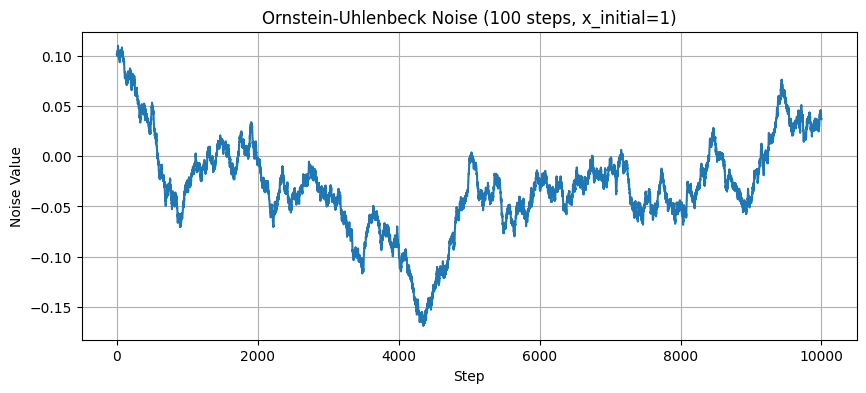

In [7]:
"""Testing the noise setup"""


std_dev = 0.02
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.02) * np.ones(1), x_initial=np.ones(1))
noise = OUActionNoise(mean=np.ones(1)/1e+8, std_deviation=float(std_dev) * np.ones(1))
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), x_initial=np.ones(1)/10)
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), x_initial=np.ones(1)/10)
noise.reset() 
x_vals = []
for _ in range(10000):
    x = noise()
    x_vals.append(x[0])

plt.figure(figsize=(10, 4))
plt.plot(x_vals)
plt.title("Ornstein-Uhlenbeck Noise (100 steps, x_initial=1)")
plt.xlabel("Step")
plt.ylabel("Noise Value")
plt.grid(True)
plt.show()


Model Setup

In [8]:
from keras import layers
from tensorflow.keras.layers import LeakyReLU

num_states = 3
num_actions = 1


def get_actor():

    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(inputs)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * 1
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    state_input = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(state_input)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    state_out = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128)(concat)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128, activation="sigmoid")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model





Training Hyperparams

In [9]:
std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1), theta=0.2)
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)


# Discount factor for future rewards
gamma = 0.90
# Used to update target networks
tau = 0.001 # recently changed from 0.005 to 0.0001

c:\Users\morus\anaconda3\envs\tf\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Buffer

In [10]:
class Buffer:
    def __init__(self, models, buffer_capacity=100_000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training = True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training = True)
            
            critic_value = critic_model([state_batch, action_batch], training = True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training = True)
            critic_value = critic_model([state_batch, actions], training = True)
            actor_loss = -keras.ops.mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)




Main

In [11]:
total_episodes = 20
print(f"Training run from {start_datetime} to {validation_datetime} with {total_episodes} episodes")


Training run from 2019-10-02 15:31:03.714872 to 2024-09-25 15:31:03.714872 with 20 episodes


In [12]:

buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

start_time = start_datetime
end_time = validation_datetime
ep_profit = []
all_states = []
all_actions = []
    
for ep in range(total_episodes):
    
    ep_start = datetime.now()
    prev_state, porfolio = reset_enviroment()
    episodic_reward = 0
    step = 0
    
    episodic_actions = []
    episodic_val_diff = []
    episodic_timesteps = []
    episodic_full_state = []

    print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")
    
    while porfolio.datetime < end_time:
        
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )
        
        action = policy(tf_prev_state, ou_noise, actor_model)
        
        state, reward, value_change = perform_action(action[0], porfolio, prev_state)
        
                
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        episodic_actions.append(action)
        episodic_val_diff.append(value_change)
        episodic_full_state.append([prev_state])

        prev_state = state 

        step+=1

    all_states.append(episodic_full_state)
    ep_reward_list.append(episodic_reward)
    
    ep_profit.append(porfolio.calc_profit())
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode profit -- start: {porfolio.init_balane}, end: {porfolio.get_portfolio_net()}, profit: {porfolio.calc_profit()}")
    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    print(f"Ending state: {state}, datetime: {porfolio.datetime.strftime('%d-%m-%Y')}\n")
    avg_reward_list.append(avg_reward)
    all_actions.append(episodic_actions)

    


Starting episode: 0, with datetime 02-10-2019, ending at 25-09-2024, state: [ 58.43164062   0.         100.        ]


ValueError: Value update not possible, '
' value: 103.91243201338769, action: 1.0, balance:-7.105427357601002e-15, state: [ 6.17593651e+01  1.03912432e+02 -7.10542736e-15], 1: 103.91243201338769, 2: 207.82486402677537 

In [ ]:
actor_model.save_weights("./params/actor_weights.weights.h5")
critic_model.save_weights("./params/critic_weights.weights.h5")

Testing

In [ ]:
end_time = datetime.now() - timedelta(weeks = 1)

In [ ]:
print(f"Testing datetime from {validation_datetime} to {end_time} ")

Testing datetime from 2024-09-25 11:52:14.497827 to 2025-09-17 12:21:20.777324 


In [ ]:
# training_years = 6
# validation_years = 1
# testing_years = 1
# start_datetime = datetime.now() - timedelta(weeks=52*training_years)
# validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
# testing_datetime = datetime.now() - timedelta(weeks = 52*testing_years)

start_datetime = validation_datetime


name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)

In [ ]:

    

training_portfolio = Simulate_Portfolio(validation_datetime)
training_portfolio.add_investment(name)
initial_state = training_portfolio.return_state(name)
prev_state = initial_state
porfolio = training_portfolio
episodic_reward = 0
step = 0

episodic_actions = []
episodic_val_diff = []
episodic_timesteps = []
episodic_full_state = []

print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")

while porfolio.datetime < end_time:

    tf_prev_state = keras.ops.expand_dims(
        keras.ops.convert_to_tensor(prev_state), 0
    )
    
    action = policy(tf_prev_state, ou_noise, actor_model)
    
    state, reward, value_change = perform_action(action[0], porfolio, prev_state)
    
            
    buffer.record((prev_state, action, reward, state))
    episodic_reward += reward
    
    # buffer.learn()

    # update_target(target_actor, actor_model, tau)
    # update_target(target_critic, critic_model, tau)

    episodic_actions.append(action)
    episodic_val_diff.append(value_change)
    episodic_full_state.append([prev_state])

    prev_state = state 
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    
    avg_reward_list.append(avg_reward)

Starting episode: 69, with datetime 25-09-2024, ending at 17-09-2025, state: [162.27975464   0.         100.        ]
Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.9728683233696989, latest:0.9728683233696989
Episodic value changes -- reward: 0.5013829855020049 avg change: 97.28683233696988, latest:97.28683233696988 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.962715938620629, latest:0.962715938620629
Episodic value changes -- reward: 1.3958661308150084 avg change: 49.935648484157625, latest:49.935648484157625 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.9636331541657809, latest:0.9636331541657809
Episodic value changes -- reward: 2.5613572772083018 avg change: 33.33185185784369, latest:33.33185185784369 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.9656894755652667, latest:0.9656894755652667
E

C:\Users\morus\AppData\Local\Temp\ipykernel_13552\2785358604.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")


Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.8877063160393373, latest:0.8877063160393373
Episodic value changes -- reward: 8.781664959608179 avg change: 2.5, latest:2.5 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.8868392720268937, latest:0.8846885457433237
Episodic value changes -- reward: 3.8189184515303367 avg change: 2.4390243902439024, latest:0.067829191575753 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.8855203776932319, latest:0.8816605996468623
Episodic value changes -- reward: 2.1810248289924345 avg change: 2.380952380952381, latest:0.0032175757921187654 

Episode 69, with avarage inf, time: 0m 7s, with 0 timesteps
Episode actions -- avg action: 0.8846699016744572, latest:0.8787476577376081
Episodic value changes -- reward: 3.9354669751621003 avg change: 2.3255813953488373, latest:0.00011111066172340145 

Episode 69, with avarage i

In [ ]:
print(episodic_full_state)

[[array([162.27975464,   0.        , 100.        ])], [array([163.11608887,  97.78821532,   2.71316766])], [array([1.64569717e+02, 1.01267163e+02, 1.28703032e-01])], [array([1.66461441e+02, 1.02556913e+02, 4.44442647e-03])], [array([1.67686081e+02, 1.03315765e+02, 1.25073095e-04])], [array([1.66580933e+02, 1.02634972e+02, 5.95175931e-06])], [array([1.66481369e+02, 1.02573634e+02, 2.92395427e-07])], [array([1.67825485e+02, 1.03401781e+02, 1.40016567e-08])], [array([1.63673660e+02, 1.00843730e+02, 2.51930032e-10])], [array([1.64977936e+02, 1.01647329e+02, 4.32009983e-12])], [array([1.62349426e+02, 1.00027834e+02, 3.69482223e-13])], [array([1.62468918e+02, 1.00101456e+02, 2.84217094e-14])], [array([163.80308533, 100.92347218,   0.        ])], [array([165.62512207, 102.04607787,   0.        ])], [array([166.17269897, 102.38345468,   0.        ])], [array([166.01342773, 102.28532339,   0.        ])], [array([163.79312134, 100.9173331 ,   0.        ])], [array([164.33078003, 101.24859903,   

In [ ]:
print(prices)

[[58.43163681]
 [58.9878273 ]
 [60.03913498]
 [59.97358322]
 [59.05239487]
 [59.70691299]
 [60.02274323]
 [60.35943985]
 [60.443367  ]
 [61.72808075]
 [61.7593689 ]
 [62.22765732]
 [61.85123825]
 [61.88401031]
 [61.71765137]
 [62.5286026 ]
 [62.62097168]
 [62.82656097]
 [64.06161499]
 [62.70191574]
 [62.63586044]
 [62.57727051]
 [63.25413895]
 [64.12963867]
 [64.16242218]
 [64.15100098]
 [64.99819183]
 [65.12285614]
 [64.51799774]
 [64.49862671]
 [64.45890045]
 [65.12731934]
 [66.28985596]
 [65.58617401]
 [65.32595062]
 [64.70966339]
 [64.62525177]
 [64.32678986]
 [64.89043427]
 [65.23110199]
 [65.20330811]
 [64.80452728]
 [64.05764008]
 [64.32381439]
 [65.57823944]
 [65.95515442]
 [66.57540894]
 [66.7213974 ]
 [66.77603912]
 [66.79391479]
 [67.05463409]
 [66.93346405]
 [67.59592438]
 [67.29547882]
 [67.17131805]
 [67.34117126]
 [67.02085876]
 [66.98361969]
 [66.7213974 ]
 [67.55767822]
 [67.13508606]
 [66.35292816]
 [66.39662933]
 [67.90381622]
 [67.57058716]
 [69.23669434]]


In [ ]:
print(episodic_full_state)

[[array([162.27975464,   0.        , 100.        ])], [array([163.11608887,  97.78821532,   2.71316766])], [array([1.64569717e+02, 1.01267163e+02, 1.28703032e-01])], [array([1.66461441e+02, 1.02556913e+02, 4.44442647e-03])], [array([1.67686081e+02, 1.03315765e+02, 1.25073095e-04])], [array([1.66580933e+02, 1.02634972e+02, 5.95175931e-06])], [array([1.66481369e+02, 1.02573634e+02, 2.92395427e-07])], [array([1.67825485e+02, 1.03401781e+02, 1.40016567e-08])], [array([1.63673660e+02, 1.00843730e+02, 2.51930032e-10])], [array([1.64977936e+02, 1.01647329e+02, 4.32009983e-12])], [array([1.62349426e+02, 1.00027834e+02, 3.69482223e-13])], [array([1.62468918e+02, 1.00101456e+02, 2.84217094e-14])], [array([163.80308533, 100.92347218,   0.        ])], [array([165.62512207, 102.04607787,   0.        ])], [array([166.17269897, 102.38345468,   0.        ])], [array([166.01342773, 102.28532339,   0.        ])], [array([163.79312134, 100.9173331 ,   0.        ])], [array([164.33078003, 101.24859903,   

In [ ]:
prices = np.array(episodic_full_state)[:,:,0]
holdings = np.array(episodic_full_state)[:,:,1]
balance = np.array(episodic_full_state)[:,:,2]

In [ ]:
print(holdings)

[[  0.        ]
 [ 97.78821532]
 [101.2671631 ]
 [102.55691285]
 [103.31576476]
 [102.63497242]
 [102.57363427]
 [103.40178058]
 [100.84372994]
 [101.64732905]
 [100.02783387]
 [100.10145583]
 [100.92347218]
 [102.04607787]
 [102.38345468]
 [102.28532339]
 [100.9173331 ]
 [101.24859903]
 [101.70868225]
 [102.33439844]
 [100.89893466]
 [100.92961126]
 [102.4386688 ]
 [103.26681483]
 [104.9844601 ]
 [108.05166901]
 [105.93529373]
 [105.91074681]
 [104.70227861]
 [105.15009306]
 [109.39510298]
 [111.81819727]
 [110.33368666]
 [111.62803619]
 [112.45618222]
 [110.72014791]
 [108.79393372]
 [106.67140996]
 [108.45653811]
 [110.16190521]
 [108.78166496]
 [103.81891845]
 [102.18102483]
 [103.93546698]
 [104.66546292]
 [104.78815993]
 [104.58573008]
 [106.11318606]
 [106.13773298]
 [108.02099241]
 [106.92906333]
 [108.26637702]
 [108.7638306 ]
 [114.5551462 ]
 [120.80707149]
 [118.91552948]
 [117.5337098 ]
 [121.69757667]
 [121.05886782]
 [116.77832081]
 [116.50194935]
 [118.50406063]
 [120.36

In [ ]:
print(balance)

[[1.00000000e+02]
 [2.71316766e+00]
 [1.28703032e-01]
 [4.44442647e-03]
 [1.25073095e-04]
 [5.95175931e-06]
 [2.92395427e-07]
 [1.40016567e-08]
 [2.51930032e-10]
 [4.32009983e-12]
 [3.69482223e-13]
 [2.84217094e-14]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

In [ ]:
print(prices)

[[162.27975464]
 [163.11608887]
 [164.56971741]
 [166.46144104]
 [167.68608093]
 [166.58093262]
 [166.48136902]
 [167.82548523]
 [163.67366028]
 [164.97793579]
 [162.34942627]
 [162.46891785]
 [163.80308533]
 [165.62512207]
 [166.17269897]
 [166.01342773]
 [163.79312134]
 [164.33078003]
 [165.07751465]
 [166.09307861]
 [163.76325989]
 [163.81304932]
 [166.26231384]
 [167.60643005]
 [170.39424133]
 [175.37245178]
 [171.93748474]
 [171.89764404]
 [169.93624878]
 [170.66307068]
 [177.55290222]
 [181.48568726]
 [179.07626343]
 [181.17704773]
 [182.52116394]
 [179.70350647]
 [176.57717896]
 [173.13223267]
 [176.02957153]
 [178.79745483]
 [176.55726624]
 [168.5025177 ]
 [165.84414673]
 [168.69168091]
 [169.87649536]
 [170.07563782]
 [169.74708557]
 [172.22621155]
 [172.26605225]
 [175.32266235]
 [173.55041504]
 [175.72093201]
 [176.52832031]
 [185.9278717 ]
 [196.07501221]
 [193.00495911]
 [190.76220703]
 [197.52033997]
 [196.48368835]
 [189.53617859]
 [189.08761597]
 [192.33712769]
 [195.35

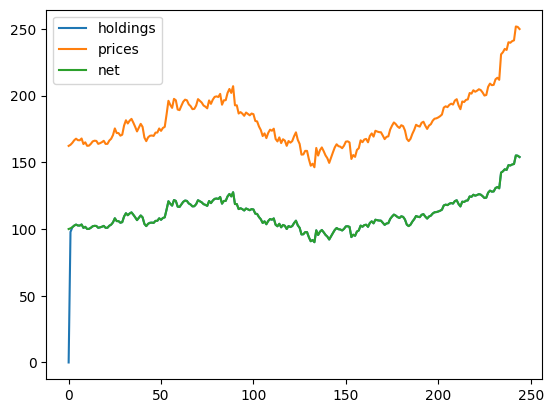

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
# plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

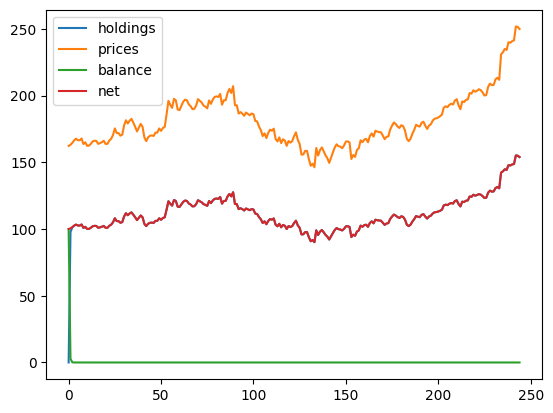

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

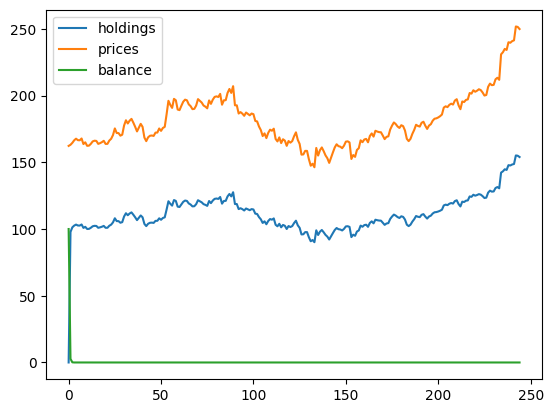

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.legend()

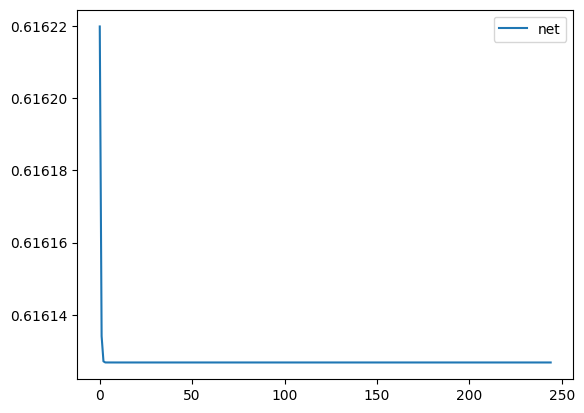

In [ ]:
timestep = list(range(len(holdings)))


plt.plot(timestep, (balance + holdings) / prices, label = 'net')
plt.legend()

This should be increasing not decreasing for a succesful model

In [ ]:
print(episodic_actions)

[[array(0.97286832)], [array(0.95256355)], [array(0.96546759)], [array(0.97185844)], [array(0.95241375)], [array(0.95087244)], [array(0.95211398)], [array(0.98200703)], [array(0.98287725)], [array(0.91504759)], [array(0.92810334)], [array(0.91027105)], [array(0.90451937)], [array(0.88546527)], [array(0.86057783)], [array(0.83201913)], [array(0.84880535)], [array(0.86081961)], [array(0.86370518)], [array(0.86769975)], [array(0.91283896)], [array(0.88042759)], [array(0.86369012)], [array(0.88076899)], [array(0.89680033)], [array(0.88736537)], [array(0.88609779)], [array(0.86762052)], [array(0.87676135)], [array(0.84758403)], [array(0.8351912)], [array(0.86253932)], [array(0.84889818)], [array(0.82834614)], [array(0.83968275)], [array(0.8303212)], [array(0.85015894)], [array(0.83196977)], [array(0.78739105)], [array(0.83372322)], [array(0.85215751)], [array(0.83144571)], [array(0.84894991)], [array(0.87158381)], [array(0.88182351)], [array(0.88202391)], [array(0.87189593)], [array(0.89606

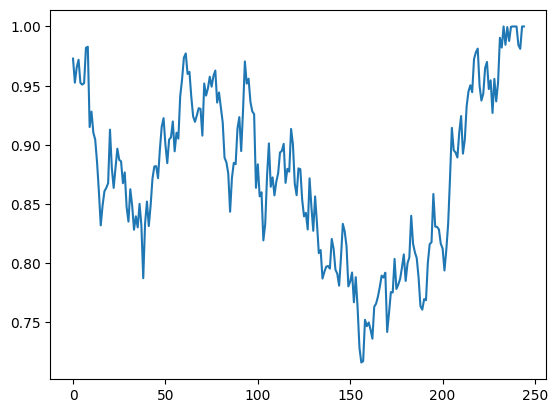

In [ ]:
plt.plot(episodic_actions)